Basic classification of stadsarchief images

In [1]:
import numpy as np
import math
from PIL import Image
from scipy import misc
import keras.backend as K
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.initializers import RandomUniform
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
 

from stats import list_stats, show_train_curves, show_prediction_list, show_prediction_images
# from stats import show_train_curves
from data import load_data, split_data
from image_display import show_image

Using TensorFlow backend.


# Load dataset

In [2]:
# IMG_DIR = 'examples/0-src/200x200/';
# LABEL_DIR = 'examples/0-src/labels/';

img_dim = (100, 100, 3);
IMG_DIR = f'examples/0-src/beeldbank-scraped_set/{img_dim[0]}x{img_dim[1]}/'
LABEL_DIR = 'examples/0-src/beeldbank-scraped_set/labels/'


[X, Y_yaml] = load_data(IMG_DIR, LABEL_DIR)
X = X / 255.  # normalize image data between 0 and 1
Y_type = np.array([y.get('type') for y in Y_yaml])

def shuffle(X, Y):
    indices = np.random.permutation(X.shape[0])
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]
    return (X_shuffled, Y_shuffled)

print('shuffling X and Y')
X_shuffled, Y_shuffled = shuffle(X, Y_type)
X = X_shuffled
Y_type = Y_shuffled

print(f"shape X: {X.shape}")
print(f"shape Y: {Y_type.shape}")

list_stats(Y_type)

first few ids: ['000000091010', '000000091053', '000000091089', '000000091123', '000000091242']
shuffling X and Y
shape X: (1201, 100, 100, 3)
shape Y: (1201,)
classes: 5
> 5 count classes: [['affiche', 8], ['foto', 250], ['bouwtekening', 338], ['prent', 575], ['kaart', 30]]
largest class: prent, count: 575
total count: 1201
score to beat: 0.4787676935886761


In [3]:
# Convert string to idx
types = list(set(Y_type))
num_classes = len(types)
print(f"number of classes: {num_classes}")
print(f"types encountered: {types}")

def convert_to_index(Y, types):
    return np.array([types.index(y) for y in Y])

Yind = convert_to_index(Y_type, types)
print(Y_type[:3])
print(Yind[:3])

list_stats(Yind)

number of classes: 5
types encountered: ['affiche', 'foto', 'bouwtekening', 'prent', 'kaart']
['prent' 'foto' 'prent']
[3 1 3]
classes: 5
> 5 count classes: [[0, 8], [1, 250], [2, 338], [3, 575], [4, 30]]
largest class: 3, count: 575
total count: 1201
score to beat: 0.4787676935886761


In [4]:
Y = keras.utils.to_categorical(Yind, num_classes)  # convert class vectors to binary class matrices
print(Yind.shape)
print(Y.shape)
print(Y[:10])

(1201,)
(1201, 5)
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]


In [5]:
# # Rebalance
# def rebalance(X, Yind):
#     types = list(set(Yind))

#     unique, counts = np.unique(Yind, return_counts=True)
#     largest = max(counts)
#     scaling = largest / counts
#     return np.array(scaling)
# scaling = rebalance(X, Yind)
# print(scaling)
# scaling_matrix = np.tile(scaling, (X.shape[0], 1) )

# Yscaled = Y * scaling_matrix
# print(Yscaled[:10])

In [6]:
# Split to train and test
SPLIT = 0.8

# (X_train, Y_train), (X_test, Y_test) = split_data(X, Yscaled, SPLIT)
(X_train, Y_train), (X_test, Y_test) = split_data(X, Y, SPLIT)

print("split data shapes:")
print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

split data shapes:
X_train: (960, 100, 100, 3)
Y_train: (960, 5)
X_test: (241, 100, 100, 3)
Y_test: (241, 5)


# Define model

In [7]:
# def build_model(num_classes, img_dim):
#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(3, 3),
#                      activation='relu',
#                      input_shape=img_dim))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model


def build_model(num_classes, img_dim):
    print(img_dim)
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=img_dim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu', kernel_initializer = RandomUniform()))
    model.add(Dense(num_classes, activation='softmax'))
    return model


def build_medium_size(num_classes, img_dim):
    # src: https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/
    print(img_dim)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=img_dim))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

model = build_model(num_classes, img_dim)
# model = build_vgg16(num_classes, img_dim)
# model = build_medium_size(num_classes, img_dim)
model.summary()

(100, 100, 3)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout

# Train

Epoch 1/50
5/5 [==============================] - 6s 1s/step - loss: 1.2316 - acc: 0.4506 - val_loss: 1.1765 - val_acc: 0.4357
Epoch 2/50
5/5 [==============================] - 5s 1s/step - loss: 1.1826 - acc: 0.4953 - val_loss: 1.2292 - val_acc: 0.4274
Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 1.1635 - acc: 0.4851 - val_loss: 1.1806 - val_acc: 0.4357
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 1.1610 - acc: 0.4988 - val_loss: 1.1634 - val_acc: 0.6224
Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 1.1019 - acc: 0.5974 - val_loss: 1.0965 - val_acc: 0.6432
Epoch 6/50
5/5 [==============================] - 6s 1s/step - loss: 1.0494 - acc: 0.5808 - val_loss: 1.0756 - val_acc: 0.5228
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 0.9567 - acc: 0.6979 - val_loss: 0.9033 - val_acc: 0.6183
Epoch 8/50
5/5 [==============================] - 6s 1s/step - loss: 0.8424 - acc: 0.7093 - val_loss: 0.9099 - 

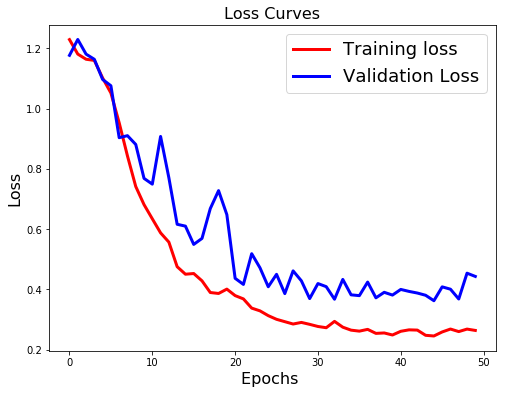

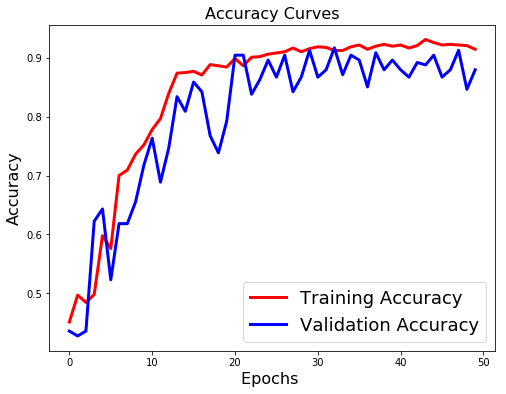

In [13]:
batch_size = 200
epochs = 50

datagen = ImageDataGenerator(
        zoom_range=0.1,        # randomly zoom into images
        rotation_range=5,      # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,# randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False    # randomly flip images
)
 
    
def compile_model(model):
    assert(K.image_data_format() == 'channels_last')
    model.compile(
        loss=keras.losses.categorical_crossentropy,
#         optimizer=keras.optimizers.Adadelta(),
#         optimizer='rmsprop',
        optimizer=keras.optimizers.Adam(),        
        metrics=['accuracy']
    )

def train(model, X_train, Y_train, X_test, Y_test, batch_size, epochs):
    compile_model(model)
    history = model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test, Y_test)
           )
    return history
# history = train(model, X_train, Y_train, X_test, Y_test, batch_size, epochs)

def train_gen(model, X_train, Y_train, X_test, Y_test, batch_size, epochs):
    compile_model(model)
    history = model.fit_generator(
        datagen.flow(X_train,
                     Y_train,
                     batch_size=batch_size
        ),
        steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
        epochs=epochs,
        validation_data=(X_test, Y_test),
        workers=4
    )
    return history
history = train_gen(model, X_train, Y_train, X_test, Y_test, batch_size, epochs)


show_train_curves(history)

In [14]:
score = model.evaluate(X_train, Y_train, verbose=1)
print('Train loss:', round(score[0], 3))
print(f'Train accuracy: {round(score[1] * 100, 2)}%')

score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', round(score[0], 3))
print(f'Test accuracy: {round(score[1] * 100, 2)}%')


960/960 [==============================] - 1s 1ms/step
Train loss: 0.362
Train accuracy: 88.75%
241/241 [==============================] - 0s 1ms/step
Test loss: 0.443
Test accuracy: 87.97%


In [15]:
print(f"types: {types}")

print("train predictions, truth")
predictions_train =  model.predict(X_train, verbose=1)
show_prediction_list(predictions_train, Y_train)

print("test predictions, truth")
predictions_test = model.predict(X_test, verbose=1)
show_prediction_list(predictions_test, Y_test)

types: ['affiche', 'foto', 'bouwtekening', 'prent', 'kaart']
train predictions, truth
960/960 [==============================] - 1s 1ms/step
index:      [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
prediction: [3 1 3 4 2 3 2 3 1 1 2 1 3 3 2 3 2 2 1 3 1 2 3 2 3 1 1 3 2 2]
expected:   [3 1 3 4 2 3 2 3 3 1 2 1 3 3 2 3 2 2 1 3 3 2 3 2 3 1 1 3 2 3]
test predictions, truth
241/241 [==============================] - 0s 1ms/step
index:      [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
prediction: [3 3 2 3 3 3 3 1 3 2 3 3 3 3 2 3 1 3 1 2 3 3 1 1 3 1 2 1 2 2]
expected:   [3 3 2 3 3 3 1 1 3 2 1 3 3 3 2 3 3 3 1 2 3 3 1 2 3 2 2 1 2 2]


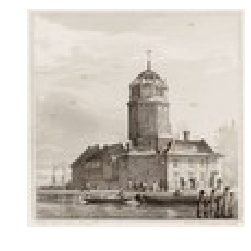

In [11]:
show_image(X_test, 11)

train set:


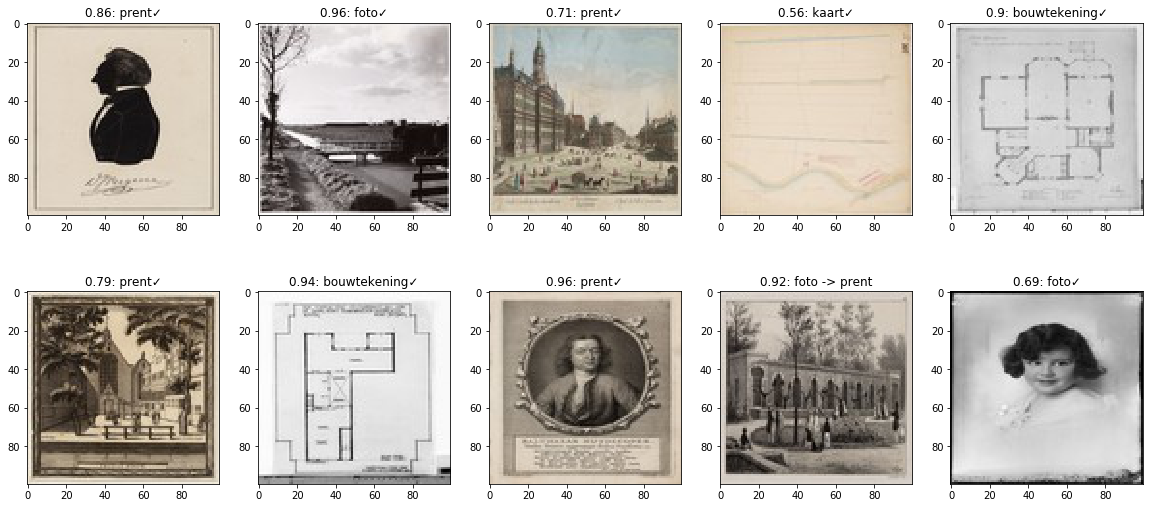

test set:


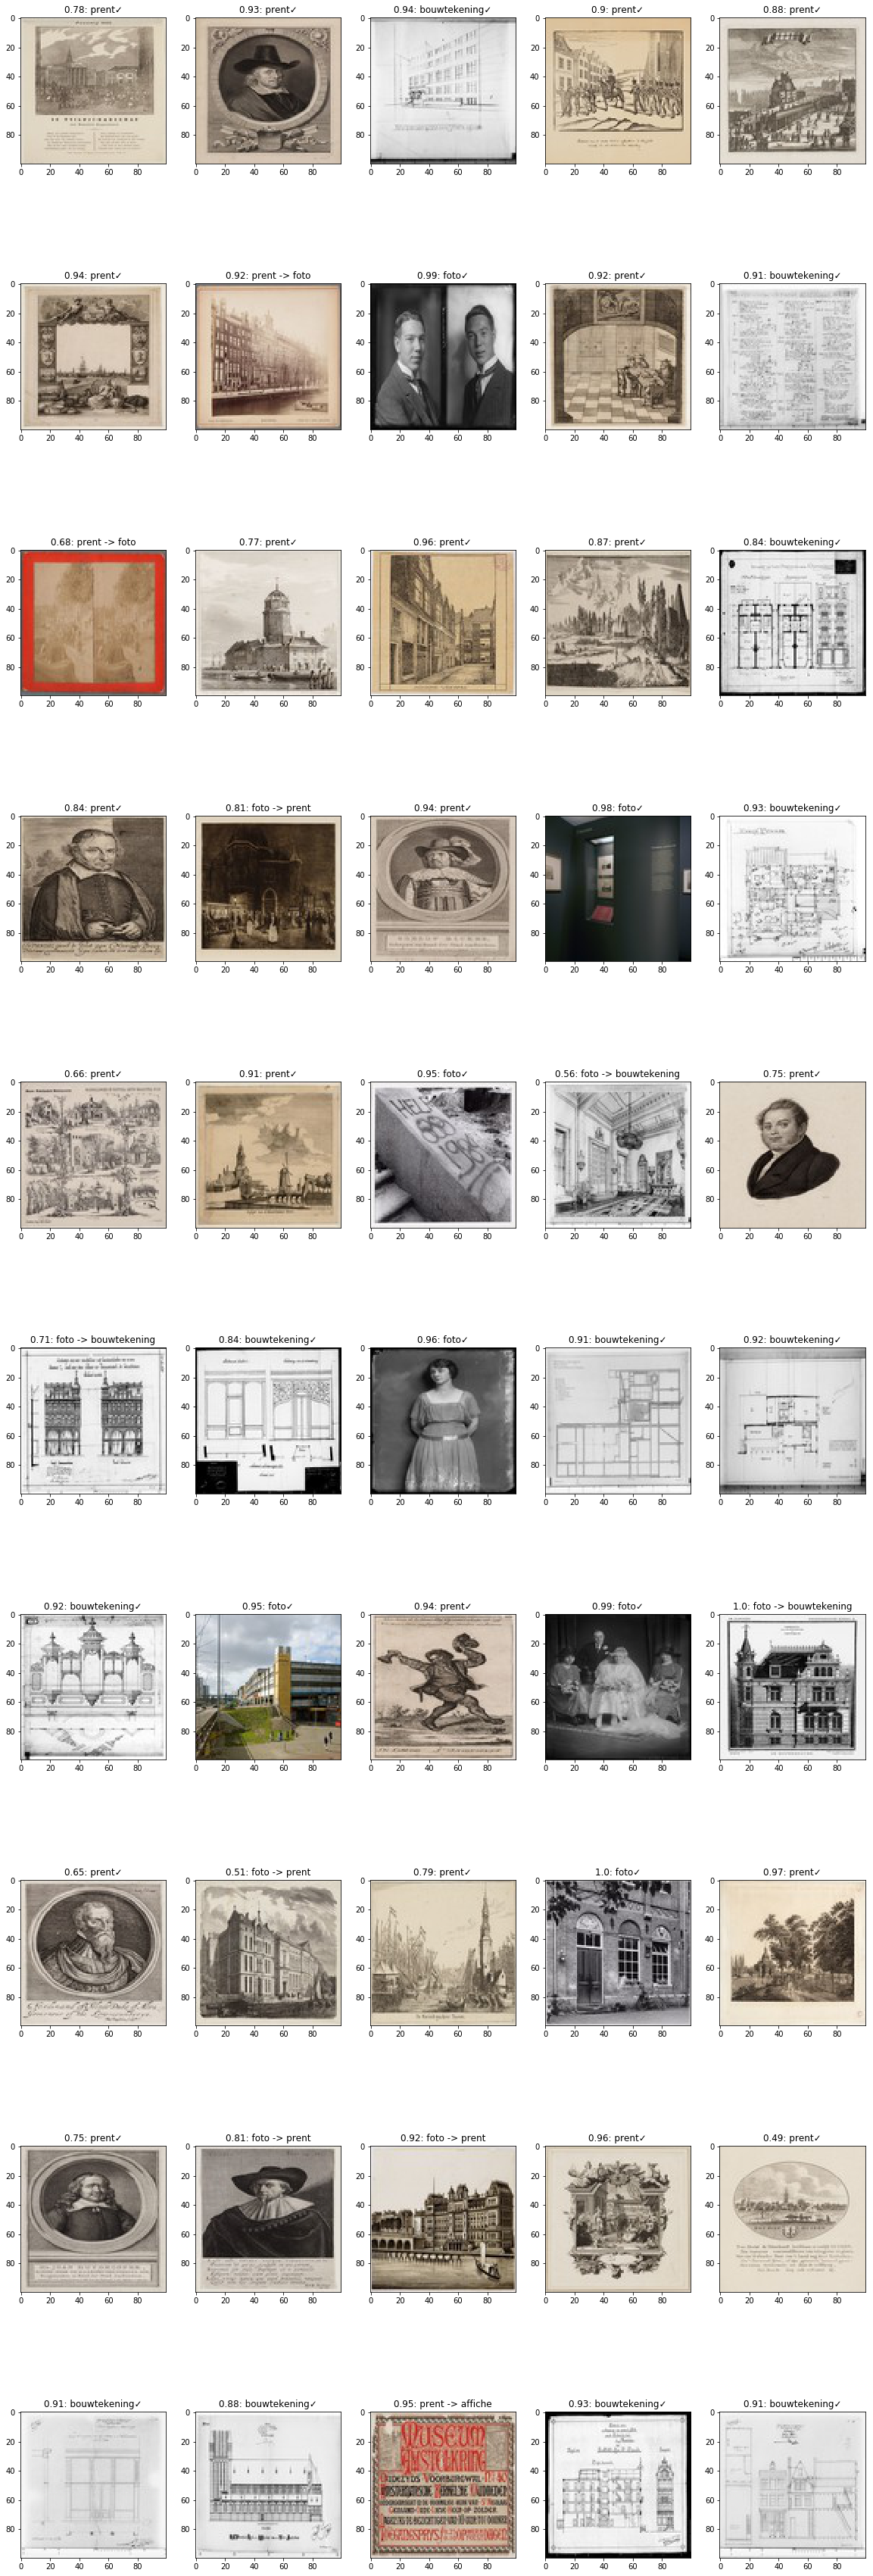

In [16]:
Y_train_idx = np.argmax(Y_train, axis=1)        
Y_test_idx = np.argmax(Y_test, axis=1)

print("train set:")
show_prediction_images(X_train, Y_train_idx, predictions_train, types, 10)

print("test set:")
show_prediction_images(X_test, Y_test_idx, predictions_test, types, 50)